In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import pytensor

from matplotlib import pyplot as plt
from pytensor import tensor as T
random_state = 108

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def exponential_transformation(row, column, bounds, k=1):
    
    
    lower_bound, upper_bound = bounds[0], bounds[1]
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range

def exponential_transformation_gender(row, column,gender_col, bounds, k=1):
    
    if row[gender_col] == 1:
        #male
        lower_bound, upper_bound = bounds["male"][0], bounds["male"][1]
    elif row[gender_col] == 0:
        lower_bound, upper_bound = bounds["female"][0], bounds["female"][1]
    else:
        return np.nan  # Unknown gender handling
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [3]:
# https://www.seslhd.health.nsw.gov.au/sites/default/files/2019-04/NSWHP%20Reference%20Ranges%20Adult%202019.pdf
train = pd.read_csv("train2.csv",index_col = 0)



train['haemoglobin_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
train['creatinine_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
train['albumin_adj'] = train.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
train['platelet_count_adj'] = train.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#train['inr_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ using mild as upperbound
train['av_peak_vel_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ 
train['av_mean_grad_tte_adj'] = train.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

train['av_area_tte_adj'] = train.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

test = pd.read_csv("test2.csv",index_col = 0)
test['haemoglobin_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
test['creatinine_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
test['albumin_adj'] = test.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
test['platelet_count_adj'] = test.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#test['inr_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))
test['av_peak_vel_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))
test['av_mean_grad_tte_adj'] = test.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

test['av_area_tte_adj'] = test.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

In [4]:
def calc_death_in_year(row,time=415):
    if row["upper_bound"] <= time and row["death_in_study"] == 1:
        return 1
    elif row["upper_bound"] > time and row["upper_bound"]!= row['lower_bound'] and row["death_in_study"] == 1:
        return 2 # this will signal that the follow up came outside the observation time
    else:
        return 0
    
train["time"] = train["event_max"].clip(upper=415)
train['death_one_year'] = train.apply(calc_death_in_year,axis=1)
train = train.query('death_one_year != 2')
train["death_one_year"] = train["death_one_year"].astype(bool)

test["time"] = test["event_max"].clip(upper=415)
test['death_one_year'] = test.apply(calc_death_in_year,axis=1)
test = test.query('death_one_year != 2')   
test["death_one_year"] = test["death_one_year"].astype(bool)

In [5]:

#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

In [6]:
categorical_columns_to_keep = [
'gender_2.0', 'cad_1.0', 'prior_acute_mi_1.0', 'prior_cardio_surg_1.0',
       'prior_pci_1.0', 'prior_cabg_1.0', 'prior_valve_replace_1.0',
       'prior_bav_1.0', 'prior_af_1.0', 'prior_generator_1.0', 'prior_ccf_1.0',
       'prior_stroke_1.0', 'prior_tia_1.0', 'prior_carotid_sten_2.0',
       'prior_carotid_sten_3.0', 'prior_carotid_sten_4.0',
       'prior_carotid_sten_5.0', 'prior_pad_1.0', 'chronic_lung_2.0',
       'chronic_lung_3.0', 'chronic_lung_4.0', 'hypertension_1.0',
       'diabetes_1.0', 'ckd_1.0', 'dialysis_1.0', 'meds_ACE_ARB_1.0',
       'meds_aspirin_1.0', 'meds_p2y12_1.0', 'meds_beta_blocker_1.0',
       'meds_doac_1.0', 'meds_statins_1.0', 'meds_diuretics_1.0',
       'nyha_status_3.0', 
    'ecg_rhythm_sinus_1.0',
       'ecg_rhythm_Fibrillation_1.0', 'ecg_rhythm_paced_1.0',
       'ecg_conduct_none_1.0', 'ecg_conduct_RBBB_1.0', 'ecg_conduct_LBBB_1.0',
       'ecg_conduct_1DAVBlock_1.0', 
    'diseased_vessels_number_2.0',
       'diseased_vessels_number_3.0', 'diseased_vessels_number_4.0',
       'prox_lad_1.0', 'aortic_insuff_2.0', 'aortic_insuff_3.0',
       'aortic_insuff_4.0', 'mitral_regurg_1.0', 'av_disease_etiology_2.0',
       'valve_calc_1.0', 'annualar_calc_ctaort_1.0', 'valve_morph_1.0',
       'artery_calc_2.0', 'artery_calc_3.0',
    'artery_calc_4.0',
       'iliofem_tort_2.0', 'iliofem_tort_3.0', 'iliofem_tort_4.0',
       'high_cfa_burif_1.0', 
    #'prev_iliofem_interv_1.0', 
    'procedure_indic_1.0',
       #'valve_in_valve_1.0', 
    'anaesthesia_2.0', 'anaesthesia_4.0',
       'initial_bav_1.0'
    ] 
    #'device_manufacturer_1_2.0',
       #'device_manufacturer_1_3.0',
        #'lvef_value_scale_2.0',
#'lvef_value_scale_3.0',
#'lvef_value_scale_4.0']
cont_columns_to_keep = [
    #'haemoglobin',
    'haemoglobin_adj',
    #'platelet_count',
    'platelet_count_adj',
    #'albumin',
    'albumin_adj',
    'creatinine',
    'creatinine_adj',
    'lvef_value',
    'av_peak_vel',	
    #'av_peak_vel_adj',
    'av_mean_grad_tte',	
    #'av_mean_grad_tte_adj',
    'av_area_tte',	
    #'av_area_tte_adj',
    'weight',
    'age',
    'kccq_summ_bl',
]
#X_train = X_train[categorical_columns_to_keep + cont_columns_to_keep]

In [7]:
X_train = X_train[list(categorical_columns_to_keep) + cont_columns_to_keep]


y = train[["death_one_year","time" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)


X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
X_test = X_test[list(categorical_columns_to_keep) + cont_columns_to_keep]
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["death_one_year","time" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [16]:
y_test

array([(False, 355.), (False, 375.), (False, 354.), ..., (False, 399.),
       (False, 364.), (False, 415.)],
      dtype=[('death_one_year', '?'), ('time', '<f8')])

In [38]:

with pm.Model() as model:
    p = pm.HalfNormal('p', sigma=1.0)
    lambda_ = pm.HalfNormal('lambda', sigma=0.1)

    # Weibull baseline hazard function
    h0 = pm.Deterministic("h0",lambda_**p * y_train["time"].astype(float)**(p - 1))
    
    # prior for regression coefficients
    beta = pm.Normal("beta", 0, sigma=1)
    
    # Adjusted hazard function including covariates
    hazard = pm.Deterministic("hazard",h0 * pm.math.exp(pm.math.dot(X_train['anaesthesia_4.0'], beta)))

    # Likelihood function to handle events and censored data
    log_likelihood = pm.math.switch(
        y["death_one_year"],
        pm.math.log(hazard) - (lambda_ * y_train["time"].astype(float))**p,  # For events
        -(lambda_ * y_train["time"].astype(float))**p                        # For censored observations
    )
    

In [39]:
sample_temp = pm.draw(log_likelihood)

In [40]:
sample_temp.shape

(7175,)

In [19]:
print(pm.draw(log_likelihood))

[[-2.31511294 -2.33787845 -2.26618578 ... -2.30935088 -2.13919657
  -2.25209975]
 [-2.31511294 -2.33787845 -2.26618578 ... -2.30935088 -2.13919657
  -2.25209975]
 [-2.31511294 -2.33787845 -2.26618578 ... -2.30935088 -2.13919657
  -2.25209975]
 ...
 [-2.31511294 -2.33787845 -2.26618578 ... -2.30935088 -2.13919657
  -2.25209975]
 [-2.31511294 -2.33787845 -2.26618578 ... -2.30935088 -2.13919657
  -2.25209975]
 [-2.31511294 -2.33787845 -2.26618578 ... -2.30935088 -2.13919657
  -2.25209975]]


In [42]:
n_samples = 1000
n_tune = 1000
with model:
    trace = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.95,
        random_seed=random_state,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, lambda, beta]


C:\Users\harri\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4991 seconds.


In [41]:
model.debug()

point={'p_log__': array(0.), 'lambda_log__': array(-2.30258509), 'beta': array(0.)}

No problems found


In [34]:
import pymc as pm
import numpy as np

# Simulated survival data with covariates
n_samples = 100
np.random.seed(42)

# Generate covariates
X = np.random.normal(0, 1, (n_samples, 2))  # Two covariates

# True parameters for simulation
true_lambda = 2.0
true_p = 1.5
true_beta = [0.5, -0.3]  # Regression coefficients

# Simulate survival times from a Weibull distribution with covariates
baseline_hazard = true_lambda * np.exp(X @ true_beta)
survival_times = (np.random.weibull(true_p, size=n_samples) / baseline_hazard)

# Simulate censoring
censoring_times = np.random.uniform(0, 2, size=n_samples)
observed_times = np.minimum(survival_times, censoring_times)
event_observed = (survival_times <= censoring_times)  # Boolean array of event occurrence

# Bayesian Cox model with Weibull baseline hazard in PyMC
with pm.Model() as model:
    # Priors for Weibull shape and scale parameters
    p = pm.HalfNormal('p', sigma=1.0)
    lambda_ = pm.HalfNormal('lambda_', sigma=1.0)
    
    # Priors for regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X.shape[1])
    
    # Weibull baseline hazard function
    h0 = lambda_**p * observed_times**(p - 1)
    
    # Adjusted hazard function including covariates
    hazard = h0 * pm.math.exp(pm.math.dot(X, beta))
    
    # Likelihood function to handle events and censored data
    log_likelihood = pm.math.switch(
        event_observed,
        pm.math.log(hazard) - (lambda_ * observed_times)**p,  # For events
        -(lambda_ * observed_times)**p                        # For censored observations
    )
    
    # Adding the likelihood to the model
    likelihood = pm.Potential('likelihood', log_likelihood.sum())
    
    # Posterior sampling
    #trace = pm.sample(1000, tune=1000, target_accept=0.95)

# Posterior summary
#pm.summary(trace)


In [35]:
with model:
    trace = pm.sample(1000, tune=1000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, lambda_, beta]


C:\Users\harri\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 444 seconds.


In [36]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],6.062,0.995,4.251,7.944,0.020,0.014,2548.0,2514.0,1.0
beta[1],1.029,1.007,-0.855,2.893,0.020,0.015,2536.0,2495.0,1.0
p,0.153,0.069,0.033,0.282,0.002,0.001,1605.0,1738.0,1.0
lambda_,0.576,0.408,0.000,1.273,0.008,0.006,1950.0,1225.0,1.0


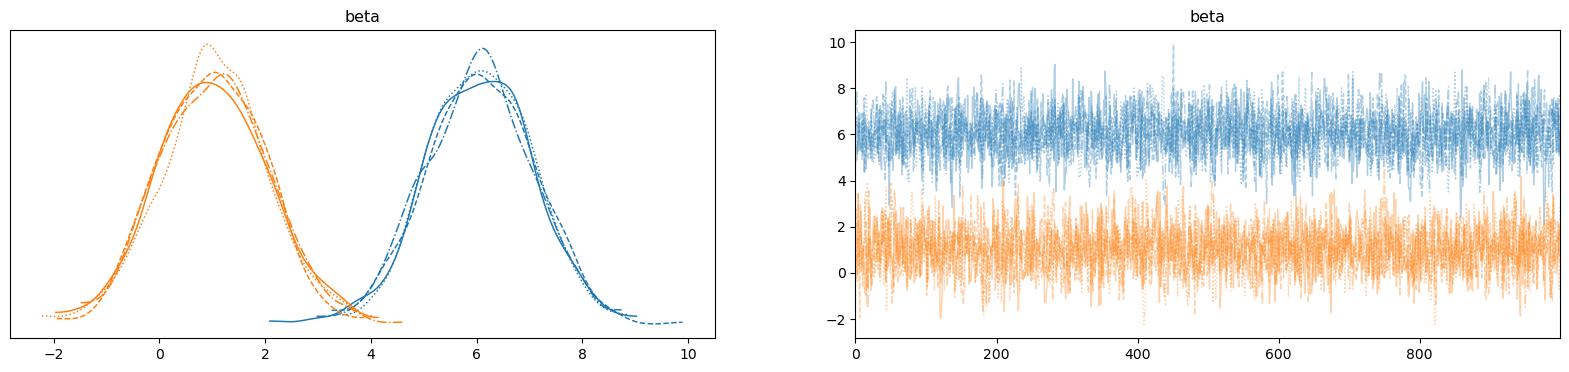

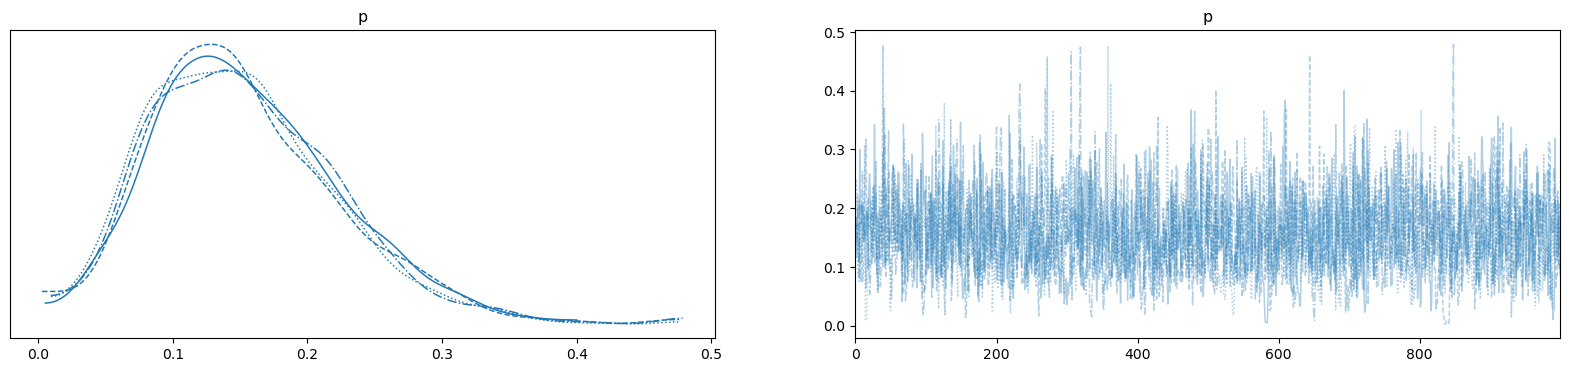

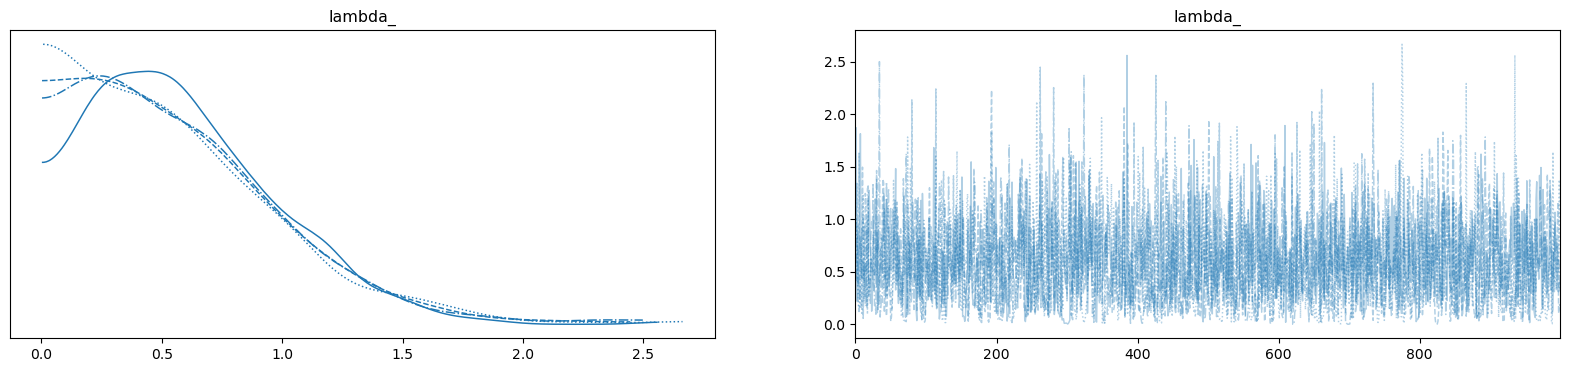

In [37]:
az.plot_trace(trace.posterior.beta,figsize=(20, 4))
az.plot_trace(trace.posterior.p,figsize=(20, 4))
az.plot_trace(trace.posterior.lambda_,figsize=(20, 4))
plt.show()